# Example of a user-defined model

## Model

-----------------------------

Example of a user-defined model reproducing the speed of the eye when smooth pursuit a target.

This model includes different parts:

- ``FIXATION`` - corresponding to a fixation of the eye on a fixation point
- ``PURSUIT`` - corresponding to the movement of the eye when tracking a moving target. This part corresponds to a linear ``acceleration`` at the beginning of the pursuit followed by a ``steady state`` of the pursuit.

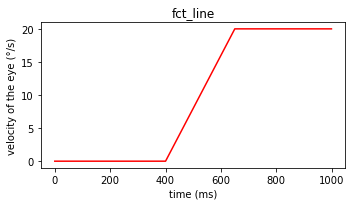

In [1]:
import numpy as np
def line_model(x, dir_target, latency, ramp_pursuit, steady_state):

    '''
    Model reproducing the velocity of the eye during the smooth pursuit of a
    moving target.

    Parameters
    ----------
    x: ndarray
        Time of the function

    dir_target: int
        Direction of the target -1 or 1
    latency: int
        Time when the movement begins
    ramp_pursuit: float
        Acceleration of pursuit in seconds
    steady_state: float
        Steady_state velocity reached during the pursuit

    Returns
    -------
    velocity: list
        Velocity of the eye in deg/sec
    '''

    ramp_pursuit = dir_target*(ramp_pursuit)/1000 # to switch from sec to ms
    steady_state_ = (dir_target*steady_state) # steady_state
    # time of end of ramp_pursuit
    t_end_r = (steady_state_/ramp_pursuit) + latency 

    velocity = []
    for t in x:
        
        #----------------------------------------------------------------------
        # FIXATION
        #----------------------------------------------------------------------
        if t<latency:
            velocity.append(0)
        
        #----------------------------------------------------------------------
        # PURSUIT
        #----------------------------------------------------------------------

        # acceleration of the pursuit
        #----------------------------------------------------------------------
        elif t<int(t_end_r):
            velocity.append((t-latency)*ramp_pursuit)
        
        # steady state of the pursuit
        #----------------------------------------------------------------------
        else:
            velocity.append(steady_state_)

    return np.array(velocity)

#------------------------------------------------------------------------------
# Plot:
#------------------------------------------------------------------------------
fct = line_model(x=np.arange(1000), dir_target=1, latency=400, ramp_pursuit=80,
                 steady_state=20)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(10/2, 10/(1.681*2)))

axs.plot(fct, 'r')
axs.set_xlabel('time (ms)')
axs.set_ylabel('velocity of the eye (°/s)')
axs.set_title('fct_line')

plt.tight_layout()
plt.show()

## Generate parameters

-----------------------------

In order to allow the parameters of this model to be fitted to the data, it is necessary to define a function to define the limits of these parameters during the fitting.

This function must return a python tuple containing two dictionaries:

- a first dictionary (called ``param`` here) which contains for each **parametric variable** of the function to be fitted a dictionary containing the following keys:
    - ``value`` - corresponding to the initial value that this variable should take
    - ``min`` - corresponding to the minimum value that this variable can take when fitted, or ``None`` for not defining a value
    - ``max`` - corresponding to the maximum value this variable can take when fitted, or `None` if you don't want to set a value
    - ``vary`` - can take three different values:
        - ``True`` - if you want the value of this variable to vary during fitting
        - ``False`` - if you want the value of this variable not to vary during the fitting and to retain the value set by ``value``.
        - ``'vary'`` - if you want to perform a two-step fit and you want the value of this variable not to vary during the first fit, but to be allowed to vary during the second fit.

- a second dictionary (called ``independent_vars`` here) which contains the values of each **non-parametric variable** (independent variable) in the function to be fitted.

In [2]:
def fct_generateParams(data, xname, trial, expname, stime, etime,
                       eventName_TargetOn='TargetOn',
                       eventName_dir_target='dir_target', **opt):

    '''
    Allows you to generate parameters to fit the line model.

    Parameters
    ----------
    data: dict, or None (default None)
        Dictionary containing for each file the Settings, the Data, the Events,
        and the Results

    xname: str
        Name of the data to be transformed
    trial: int
        Number of the trial to be transformed
    expname: str
        Name of the particular experience to be transformed

    stime: int, or None (defaut None)
        Start time of the fitting
    etime: int, or None (default -280)
        End time of the fitting

    eventName_TargetOn: str (default 'TargetOn')
        Name of the event marking the appearance of the target
    eventName_dir_target: str (default 'dir_target')
        Name of the event giving the direction of the target
    '''

    # data of the trial
    trial_data = data[expname].Data[data[expname].Data.trial==trial]
    
    # data x of the trial
    data_ = trial_data[xname].values[stime:etime]
    
    # data time of the trial
    time = trial_data['time'].values[stime:etime]

    # data events
    events = data[expname].Events
    # data events of the trial
    trial_events = events[events.trial==trial]
    
    # time of the event marking the appearance of the target in trial
    TargetOn = trial_events[eventName_TargetOn].values[0] - time[0]
    
    
    ###########################################################################
    # Dictionary containing the values of each parametric variable
    ###########################################################################
    params = dict()
    
    #==========================================================================
    # the variable corresponding to the direction of the target (dir_target)
    #  must not vary during the fitting
    #==========================================================================
    
    #--------------------------------------------------------------------------
    # Allows you to set the dir_target variable between [-1, 1]
    #--------------------------------------------------------------------------
    min_dir = np.min(events[eventName_dir_target].values)
    max_dir = np.max(events[eventName_dir_target].values)
    dir_target = events[events.trial==trial][eventName_dir_target].values[0]
    dir_target = ((dir_target-min_dir)*2-(max_dir-min_dir)) / (max_dir-min_dir)
    #--------------------------------------------------------------------------
    
    params['dir_target'] = {'value': dir_target,
                            'min': None,
                            'max': None,
                            'vary': False}
    
    #==========================================================================
    # the variable corresponding to the time when the movement begins (latency)
    #  takes an initial value (start_latency) at the time of fitting
    #  but can vary from a minimum value (TargetOn+75) to a maximum value
    #  (max_latency)
    #==========================================================================
    
    #--------------------------------------------------------------------------
    # blocks the latency variable before the first saccade
    #--------------------------------------------------------------------------
    start_latency = TargetOn+100 # initial value
    max_latency = None # maximum value
    
    # loop to lock max_latency at the beginning of the first saccade after
    # start_latency
    # time where the saccades are located in the data
    saccades = np.argwhere(np.isnan(data_))[:, 0] 
    for x in saccades:
        if x>=start_latency:
            max_latency=x # takes the value of the start of the saccade if it
                          # comes just after start_latency.
            break # stop the loop
    
    # if there was no saccade just after start_latency then max_latency is the
    # end of the data  
    if not max_latency:
        max_latency=len(data_)
        
    # if start_latency is too close to max_latency
    #  then we modify this variable to allow the fit to have a little more
    #  freedom
    if start_latency>=max_latency-50:
        start_latency = max_latency-150
    if start_latency>250:
        start_latency = TargetOn+100
    #--------------------------------------------------------------------------
    
    params['latency'] = {'value': start_latency,
                         'min': TargetOn+75,
                         'max': max_latency,
                         'vary': True}
    
    #==========================================================================
    # the variable corresponding to the steady_state velocity reached during 
    # the pursuit (steady_state)
    #  takes an initial value (15) at the time of fitting
    #  but can vary from a minimum value (5) to a maximum value (40)
    #==========================================================================
    
    params['steady_state'] = {'value': 15.,
                              'min': 5.,
                              'max': 40.,
                              'vary': True}
    
    #==========================================================================
    # the variable corresponding to the acceleration of pursuit in seconds
    # (ramp_pursuit)
    #  takes an initial value (40) at the time of fitting
    #  does not vary during the first fitting
    #  but can vary during the second fitting from a minimum value (40) to a
    #  maximum value (80)
    #==========================================================================
    
    params['ramp_pursuit'] = {'value': 40.,
                              'min': 40.,
                              'max': 80.,
                              'vary': 'vary'}
    
    
    ###########################################################################
    # Dictionary containing the values of each non-parametric variable
    ###########################################################################
    independent_vars = dict()
    
    #==========================================================================
    # the variable corresponding to the time of the function (x)
    #  takes as value an arange list of the same length as the data
    #==========================================================================
    
    independent_vars['x'] = np.arange(len(time))
    
    
    return (params, independent_vars)

## Test the parameters

-----------------------------

{'values_fit': {'dir_target': 1.0, 'latency': 1036.7795796529049, 'steady_state': 14.81763321324991, 'ramp_pursuit': 79.99999991636489}, 'FitStatistics': {'nfev': 184, 'chisqr': 31553.718115463435, 'redchi': 22.252269474938952, 'aic': 4411.569755997958, 'bic': 4427.347104382249}, 'fit': array([ 0.,  0.,  0., ..., nan, nan, nan])}


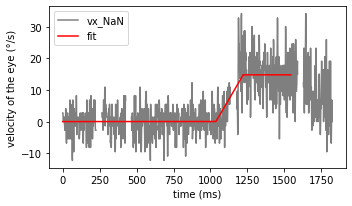

In [3]:
import ANEMO

Processing = ANEMO.ProcessingSmoothPursuit(dirpath='dataANEMO', sub='002')

#------------------------------------------------------------------------------
# Parameters:
#------------------------------------------------------------------------------
xname = 'vx_NaN' # The velocity of the eye de-saccade in deg/sec
trial = 8 # Number of the trial to be transformed
expname = 'sub-002_task-aSPEM' # Name of the particular experience to be
                               # transformed
                               # or list(PreProcessing.data.keys())[0]
model = line_model # Model equation
# Function generating parameters to perform the fitting
generate_params = fct_generateParams
stime = None # Start time of the fitting
etime = -280 # End time of the fitting
step_fit = 2 # Number of steps for the fit
# Dictionary containing the parameters for the generate_params function
arg_generate_params = dict(eventName_TargetOn='TargetOn',
                           eventName_dir_target='dir_target') 
toxname = None # Name of the data to be saved
return_ = True # If True returns the value, else saves it in results and data

#------------------------------------------------------------------------------
# to apply the function:
#------------------------------------------------------------------------------
Fit = Processing.Trial.Fit(xname,
                           trial,
                           expname,
                           model,
                           generate_params,
                           stime,
                           etime,
                           step_fit,
                           arg_generate_params,
                           toxname,
                           return_)
print(Fit)

#---------------------------------------------------------------------------
# to retrieve the raw data:
#---------------------------------------------------------------------------
data_exp = Processing.data[expname]
data = data_exp.Data
vx_NaN = data[data.trial==trial][xname].values

#---------------------------------------------------------------------------
# Plot:
#---------------------------------------------------------------------------
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(10/2, 10/(1.681*2)))

axs.plot(vx_NaN, 'k', alpha=.5, label='vx_NaN')
axs.plot(Fit['fit'], 'r', label='fit')
axs.set_xlabel('time (ms)')
axs.set_ylabel('velocity of the eye (°/s)')
axs.legend()

plt.tight_layout()
plt.show()

## Run it on a data set

----------------------------

In [4]:
import ANEMO

Processing = ANEMO.ProcessingSmoothPursuit(dirpath='dataANEMO', sub='002')

#---------------------------------------------------------------------------
# Parameters:
#---------------------------------------------------------------------------
xname = 'vx_NaN' # The velocity of the eye de-saccade in deg/sec
model = line_model # Model equation
# Function generating parameters to perform the fitting
generate_params = fct_generateParams
stime = None # Start time of the fitting
etime = -280 # End time of the fitting
step_fit = 2 # Number of steps for the fit
# Dictionary containing the parameters for the generate_params function
arg_generate_params = dict(eventName_TargetOn='TargetOn',
                           eventName_dir_target='dir_target') 
toxname = None # Name of the data to be saved
expnames = 'sub-002_task-aSPEM' # Name of the particular experience to be
                                # transformed
                                # or list(PreProcessing.data.keys())[0] 
trials = trials = list(range(1, 16)) # List of the trial to be transformed
recalculate = False # Allows you to indicate if you want to force the
                    # calculation on the trials already processed
    
#------------------------------------------------------------------------------
# to apply the function:
#------------------------------------------------------------------------------
Processing.Data.Fit(xname,
                    model,
                    generate_params,
                    stime,
                    etime,
                    step_fit,
                    arg_generate_params,
                    toxname,
                    expnames,
                    trials,
                    recalculate)

calculates Fit_line_model from the file sub-002_task-aSPEM... finished
